In [3]:
!pip install tensorflow

  Using cached tensorflow-2.9.1-cp38-cp38-win_amd64.whl (444.1 MB)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv1D, MaxPooling1D,GlobalAveragePooling1D,GlobalAvgPool1D, Reshape, Activation
from keras import optimizers
import keras
from keras.utils import np_utils

#%matplotlib inline
plt.style.use('ggplot')
from keras.optimizers import SGD

In [2]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

In [3]:
def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

In [4]:
dataset = read_data('/Stage 4A/data2.txt')
dataset.dropna(axis=0, how='any', inplace= True)
dataset = dataset.sort_values(by = ['user-id','timestamp'],ignore_index = True)
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

In [5]:
dataset.head

<bound method NDFrame.head of          user-id  activity       timestamp    x-axis    y-axis    z-axis
0              1   Walking   4991922345000  0.003962  0.525386 -0.513464
1              1   Walking   4991972333000  0.903356  0.027328 -0.191637
2              1   Walking   4992022351000  0.039003 -0.240971 -0.191637
3              1   Walking   4992072339000 -0.404853 -0.332875 -0.231602
4              1   Walking   4992122358000 -0.766947 -0.439602 -0.496636
...          ...       ...             ...       ...       ...       ...
1098198       36  Standing  15049012250000 -0.229647  0.322308  0.446419
1098199       36  Standing  15049062268000 -0.269068  0.334167  0.437824
1098200       36  Standing  15049112287000 -0.315790  0.337132  0.446419
1098201       36  Standing  15049162275000 -0.399013  0.224476  0.371930
1098202       36  Standing  15049212262000 -0.409234  0.390495  0.598262

[1098203 rows x 6 columns]>

In [6]:
'''***********************'''
#DEFINE NETWORK PARAMETERS
trainSplitRatio = 0.7 # split ratio for test and validation
window_size = 50 #Length of time slice. 50 Hz in each sequence
numFilters1 = 100 # number of filters in first Conv1D layer
kernalSize = 3 # kernal size of the Conv1D layer
batchSize = 10
numNueronsFCL2 = 160 # number of filters in fully connected output layer 
dropout = 0.5 #dropout rate. % of neurons converted to 0 weight before softmax
epochs = 50 # number of iterations


In [8]:
step = 10
N_TIME_STEPS = 50 
N_FEATURES = 3
segments = []
labels = []

for i in range(0,  dataset.shape[0]-N_TIME_STEPS, step):  
    xs = dataset['x-axis'].values[i: i + 50]
    ys = dataset['y-axis'].values[i: i + 50]
    zs = dataset['z-axis'].values[i: i + 50]
    label = stats.mode(dataset['activity'][i: i + 50])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

#reshape the segments which is (list of arrays) to one list
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(len(segments), N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
reshaped_segments.shape

(109816, 50, 3)

In [9]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = 20)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)




(87852, 50, 3) (87852, 6)
(21964, 50, 3) (21964, 6)


In [10]:
numOfRows = reshaped_segments.shape[1]
numOfColumns = reshaped_segments.shape[2]
num_classes = labels.shape[1]
num_data_parameters = X_train.shape[2]
input_shape = window_size*num_data_parameters

print(input_shape)

150


In [17]:
print(numOfRows)
print(numOfColumns)



50
3


In [13]:
#DEFINE CNN MODEL
# 1D CNN neural network

model_m = Sequential()
model_m.add(Reshape((window_size, num_data_parameters), input_shape=(numOfRows,numOfColumns)))
model_m.add(Conv1D(numFilters1, kernalSize, activation='relu', input_shape=(window_size, num_data_parameters)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(numNueronsFCL2, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())

model_m.add(Dropout(dropout))

model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 48, 100)           1000      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 16, 100)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 160)            160160    
                                                                 
 global_average_pooling1d_1   (None, 160)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                

In [20]:
pip install plot_model

In [22]:
from plot_model import plot_model



In [25]:
plot_model(model_m, show_shapes=True, show_layer_names=False,  expand_nested=False, style=0, color=True)

ImportError: cannot import name 'wrappers' from 'tensorflow.python.keras.layers' (c:\Users\thanh\anaconda3\lib\site-packages\tensorflow\python\keras\layers\__init__.py)

In [14]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='loss', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 1024
EPOCHS = epochs

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
69/69 [==============================] - 12s 125ms/step - loss: 0.9571 - accuracy: 0.6468 - val_loss: 0.6812 - val_accuracy: 0.7412
Epoch 2/50
69/69 [==============================] - 7s 107ms/step - loss: 0.6456 - accuracy: 0.7722 - val_loss: 0.5259 - val_accuracy: 0.8125
Epoch 3/50
69/69 [==============================] - 7s 106ms/step - loss: 0.5377 - accuracy: 0.8117 - val_loss: 0.4557 - val_accuracy: 0.8320
Epoch 4/50
69/69 [==============================] - 7s 101ms/step - loss: 0.4827 - accuracy: 0.8291 - val_loss: 0.4107 - val_accuracy: 0.8510
Epoch 5/50
69/69 [==============================] - 8s 112ms/step - loss: 0.4427 - accuracy: 0.8444 - val_loss: 0.3832 - val_accuracy: 0.8684
Epoch 6/50
69/69 [==============================] - 8s 121ms/step - loss: 0.4156 - accuracy: 0.8558 - val_loss: 0.3557 - val_accuracy: 0.8822
Epoch 7/50
69/69 [==============================] - 8s 117ms/step - loss: 0.3939 - accuracy: 0.8631 - val_loss: 0.3347 - val_accuracy: 0.8853
Epoch

In [15]:
score = model_m.evaluate(X_test,y_test,batch_size=BATCH_SIZE, verbose=2)
print("The test accuracy is",score[1]*100,"%")

22/22 - 1s - loss: 0.1799 - accuracy: 0.9390 - 1s/epoch - 48ms/step
The test accuracy is 93.90366077423096 %


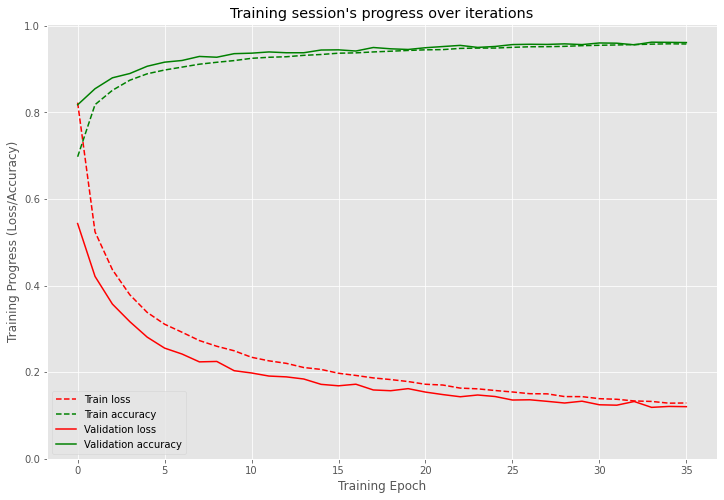

In [43]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [59]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [74]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [71]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [76]:
# Confusion Matrix

predictions = model_m.predict(X_test)
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True,
            linewidths = 0.1, fmt="d", cmap = 'YlGnBu');
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


687/687 [==============================] - 1s 2ms/step


AttributeError: module 'numpy' has no attribute 'matrix'